<a href="https://colab.research.google.com/github/WafaSanaa/NLP_ia/blob/main/chest_X_RAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sannaa95","key":"769f0c41225d26f01733a3918e2e0dd9"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 268MB/s]
100% 2.29G/2.29G [00:21<00:00, 117MB/s]


In [10]:
!rm -r chest_xray

In [11]:
!unzip chest-xray-pneumonia.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

In [12]:
!ls

 chest_xray   chest-xray-pneumonia.zip	'kaggle (1).json'   sample_data


In [13]:
!mv "kaggle (1).json" kaggle.json

Processing class: PNEUMONIA


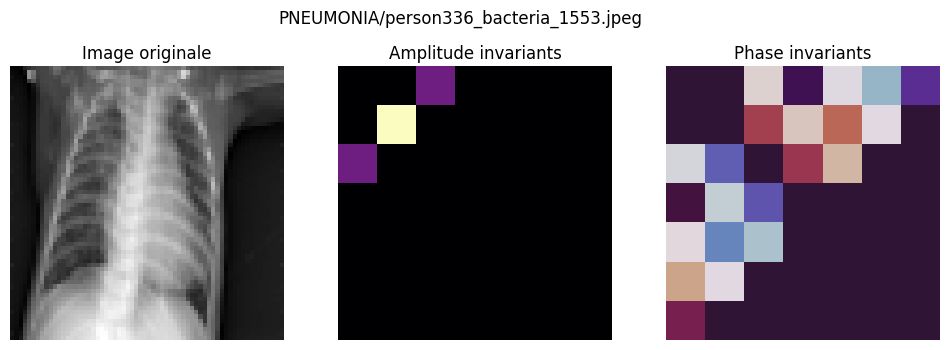

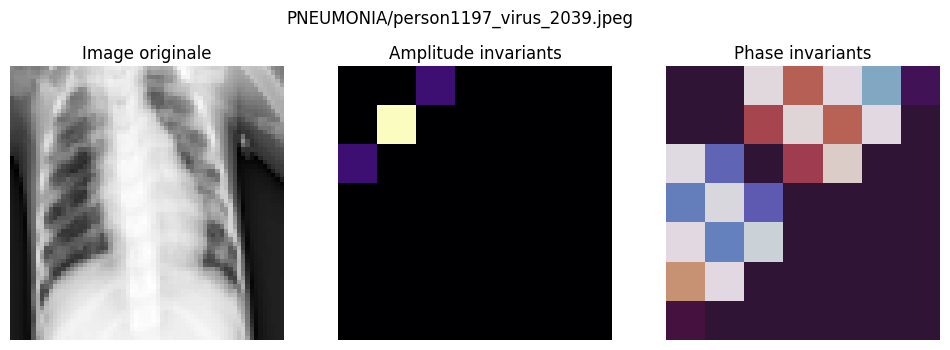

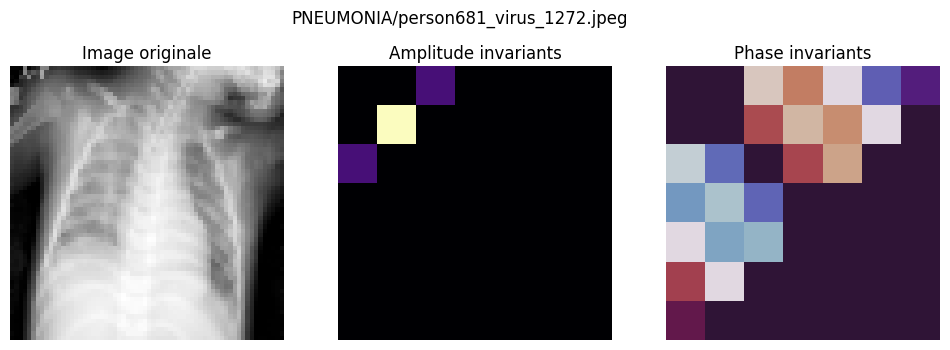

Skipping /content/chest_xray/chest_xray/train/.DS_Store: Not a directory.
Processing class: NORMAL


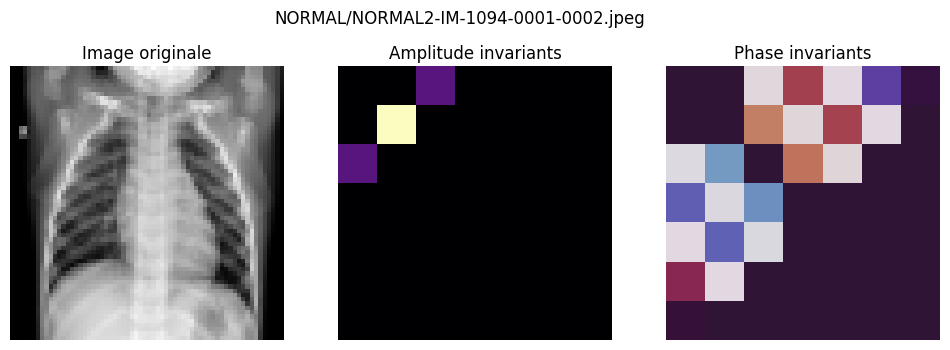

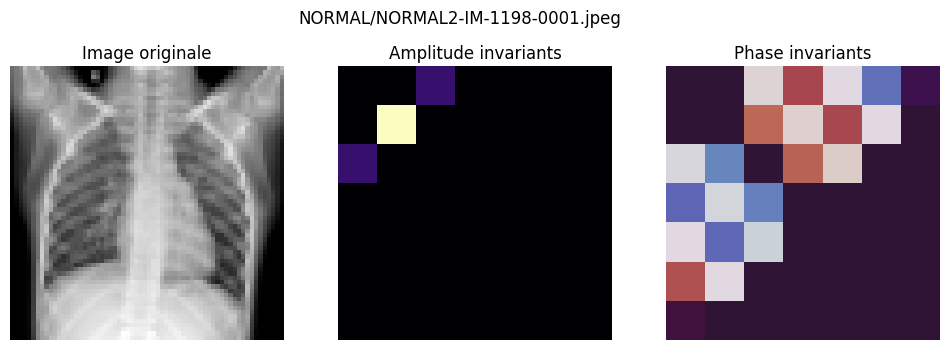

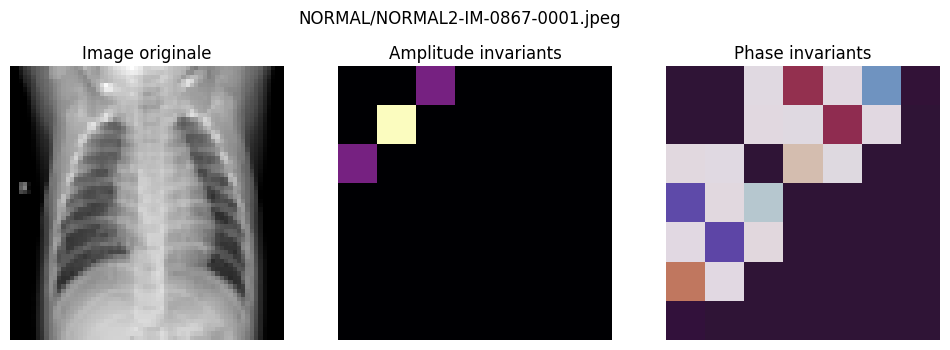

Calcul et sauvegarde des invariants de Ghorbel terminé pour tout le dataset. Total features saved: 5216


In [17]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class GhorbelInvariantExtractor:
    def __init__(self, max_order=6, image_size=(64, 64)):
        self.max_order = max_order
        self.image_size = image_size

    def load_and_preprocess_image(self, image_path):
        try:
            image = Image.open(image_path)
            image = np.array(image)
        except Exception:
            image = cv2.imread(image_path)
            if image is None:
                return None
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if image.shape != self.image_size:
            image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)
        image = image.astype(np.float64) / 255.0
        return image

    def calculate_geometric_center(self, image):
        M00 = np.sum(image)
        if M00 == 0:
            return image.shape[1]//2, image.shape[0]//2
        y_coords, x_coords = np.indices(image.shape)
        x_center = np.sum(x_coords * image) / M00
        y_center = np.sum(y_coords * image) / M00
        return x_center, y_center

    def calculate_complex_moments(self, image):
        height, width = image.shape
        y_coords, x_coords = np.indices(image.shape)
        xc, yc = self.calculate_geometric_center(image)
        x_centered = x_coords - xc
        y_centered = y_coords - yc
        scale = min(height, width) / 2.0
        x_normalized = x_centered / scale
        y_normalized = y_centered / scale
        z = x_normalized + 1j * y_normalized
        z_conj = x_normalized - 1j * y_normalized
        F = np.zeros((self.max_order+1, self.max_order+1), dtype=np.complex128)
        for p in range(self.max_order+1):
            for q in range(self.max_order+1):
                if p + q <= self.max_order:
                    moment = np.sum(image * (z**p) * (z_conj**q))
                    F[p, q] = moment
        return F

    def calculate_ghorbel_invariants(self, F):
        S = np.zeros((self.max_order+1, self.max_order+1), dtype=np.complex128)
        F00 = F[0, 0]
        if np.abs(F00) < 1e-10:
            F00 = 1e-10
        for p in range(self.max_order+1):
            for q in range(self.max_order+1):
                if p + q <= self.max_order and p + q >= 2:
                    exponent = (p + q + 2) / 2.0
                    denominator = F00 ** exponent
                    if np.abs(denominator) > 1e-10:
                        S[p, q] = F[p, q] / denominator
        return S

    def extract_invariants_from_image(self, image_path):
        image = self.load_and_preprocess_image(image_path)
        if image is None:
            print(f"Impossible de charger l'image: {image_path}")
            return None, None
        F = self.calculate_complex_moments(image)
        S = self.calculate_ghorbel_invariants(F)
        return image, S

def save_features(features, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, features)

def extract_dataset_features(dataset_dir, output_dir, max_order=6, image_size=(64,64), nb_examples=3):
    extractor = GhorbelInvariantExtractor(max_order=max_order, image_size=image_size)
    processed_count = 0
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"Skipping {class_path}: Not a directory.")
            continue
        print(f"Processing class: {class_name}")
        example_counter = 0
        for file_name in os.listdir(class_path):
            image_path = os.path.join(class_path, file_name)
            if not (file_name.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff','.tif'))):
                continue

            img, S = extractor.extract_invariants_from_image(image_path)
            if img is None:
                # Error message already printed by extractor.extract_invariants_from_image
                continue

            mag = np.abs(S)
            phase = np.angle(S)
            both = np.concatenate([mag.flatten(), phase.flatten()])
            base = os.path.splitext(file_name)[0]
            mag_path = os.path.join(output_dir, 'magnitude', class_name, base + ".npy")
            phase_path = os.path.join(output_dir, 'phase', class_name, base + ".npy")
            both_path = os.path.join(output_dir, 'both', class_name, base + ".npy")
            save_features(mag, mag_path)
            save_features(phase, phase_path)
            save_features(both, both_path)
            processed_count += 1
            # Affichage pour nb_examples images seulement
            if example_counter < nb_examples:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Image originale")
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.title("Amplitude invariants")
                plt.imshow(np.log1p(mag), cmap='magma')
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.title("Phase invariants")
                plt.imshow(phase, cmap='twilight')
                plt.axis('off')
                plt.suptitle(f"{class_name}/{file_name}")
                plt.show()
                example_counter += 1
    print(f"Calcul et sauvegarde des invariants de Ghorbel terminé pour tout le dataset. Total features saved: {processed_count}")

# ==== UTILISATION ====
dataset_dir = "/content/chest_xray/chest_xray/train"    # dossier racine contenant les dossiers de chaque classe
output_dir = "/kaggle/working/Ghorbel_features"  # dossier où stocker les features
extract_dataset_features(dataset_dir, output_dir, max_order=6, image_size=(64,64), nb_examples=3)

In [15]:
!pip install torch torchvision

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# --- Configuration ---
BASE_IMAGE_PATH = '/content/chest_xray/chest_xray/train'
FEATURES_PATH_FLAT = '/kaggle/working/Ghorbel_features/both'
CATEGORIES = ['NORMAL', 'PNEUMONIA']
IMG_WIDTH, IMG_HEIGHT = 128, 128

VALIDATION_SPLIT_SIZE = 0.4
EPOCHS = 100

# Configurations différentielles
BASELINE_CONFIG = {
    'batch_size': 8,
    'lr': 5e-5,
    'weight_decay': 1e-3,
    'dropout': 0.7
}

FUSION_CONFIG = {
    'batch_size': 16,
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'dropout': 0.5
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Data Preparation ---
print("Matching images to their pre-calculated feature files...")
image_files, flat_feature_files, labels = [], [], []

# Define common image extensions to check
IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')

for i, category in enumerate(CATEGORIES):
    feature_dir = os.path.join(FEATURES_PATH_FLAT, category)
    if not os.path.isdir(feature_dir):
        print(f"Skipping feature directory {feature_dir}: Does not exist.")
        continue
    for feature_filename in os.listdir(feature_dir):
        base_name = os.path.splitext(feature_filename)[0]

        # Dynamically find the correct image file extension
        found_image_path = None
        for ext in IMAGE_EXTENSIONS:
            potential_image_path = os.path.join(BASE_IMAGE_PATH, category, base_name + ext)
            if os.path.exists(potential_image_path):
                found_image_path = potential_image_path
                break

        if found_image_path:
            image_files.append(found_image_path)
            flat_feature_files.append(os.path.join(FEATURES_PATH_FLAT, category, feature_filename))
            labels.append(i)
        # else:
        #     print(f"Warning: No matching image found for feature file: {feature_filename} in category {category}")

print(f"Found {len(image_files)} total valid image-feature pairs.")

X_train, X_val, y_train, y_val = train_test_split(
    list(zip(image_files, flat_feature_files)),
    labels,
    test_size=VALIDATION_SPLIT_SIZE,
    random_state=42,
    stratify=labels
)
print(f"Dataset split: {len(y_train)} train, {len(y_val)} val.")

if X_train and X_val:
    train_images, train_flat = zip(*X_train)
    val_images, val_flat = zip(*X_val)
else:
    train_images, train_flat, val_images, val_flat = [], [], [], []

# --- 2. Data Augmentation (Différentielle) ---

# Transform BASELINE : Augmentation minimale
transform_baseline = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform FUSION : Augmentation standard
transform_fusion = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform validation (sans augmentation)
transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Custom Dataset ---
class MultiModalDataset(Dataset):
    def __init__(self, image_paths, flat_paths, labels, mode='baseline', transform=None):
        self.image_paths, self.flat_paths = image_paths, flat_paths
        self.labels, self.mode, self.transform = labels, mode, transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.mode == 'baseline':
            return image, label.unsqueeze(0)
        elif self.mode == 'vector_fusion':
            raw_features = np.load(self.flat_paths[idx])
            # Assuming raw_features contains concatenated magnitude and phase
            # The original code implies an alternating pattern, let's keep that
            # for consistent feature representation during fusion.

            # Correct way to separate magnitude and phase if 'both' means [mag1, phase1, mag2, phase2, ...]
            # However, the extraction saves `both = np.concatenate([mag.flatten(), phase.flatten()])`
            # This means it's [mag_all_flattened, phase_all_flattened]

            # We need the number of magnitudes to correctly split
            # This requires knowing the shape of S which is (max_order+1, max_order+1)
            # In our case max_order=6, so S is (7,7)
            # S.flatten() will be 49 elements. mag.flatten() will be 49, phase.flatten() will be 49.
            # So raw_features will have 98 elements.

            # The correct num_mag_elements should be based on the shape of S from GhorbelInvariantExtractor
            # (max_order+1)*(max_order+1)
            # Given max_order=6, S is 7x7, so 49 elements.
            num_ghorbel_moments = (6+1)*(6+1) # From GhorbelInvariantExtractor

            amplitudes = raw_features[:num_ghorbel_moments]
            phases = raw_features[num_ghorbel_moments:]

            cos_phases, sin_phases = np.cos(phases), np.sin(phases)
            final_vector = np.concatenate([amplitudes, cos_phases, sin_phases])
            features = torch.from_numpy(final_vector).float()
            return image, features, label.unsqueeze(0)

# Datasets BASELINE avec transform minimal
train_ds_base = MultiModalDataset(
    train_images, train_flat, y_train,
    'baseline',
    transform_baseline
) if train_images else None

val_ds_base = MultiModalDataset(
    val_images, val_flat, y_val,
    'baseline',
    transform_val
) if val_images else None

# DataLoaders BASELINE avec petit batch
train_loader_base = DataLoader(
    train_ds_base,
    batch_size=BASELINE_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2
) if train_ds_base else None

val_loader_base = DataLoader(
    val_ds_base,
    batch_size=BASELINE_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2
) if val_ds_base else None

# Datasets FUSION avec transform standard
train_ds_vector = MultiModalDataset(
    train_images, train_flat, y_train,
    'vector_fusion',
    transform_fusion
) if train_images else None

val_ds_vector = MultiModalDataset(
    val_images, val_flat, y_val,
    'vector_fusion',
    transform_val
) if val_images else None

# DataLoaders FUSION avec batch normal
train_loader_vector = DataLoader(
    train_ds_vector,
    batch_size=FUSION_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2
) if train_ds_vector else None

val_loader_vector = DataLoader(
    val_ds_vector,
    batch_size=FUSION_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2
) if val_ds_vector else None

# --- 4. Feature Sizes ---
if train_flat:
    temp_features = np.load(train_flat[0])
    # Assuming num_ghorbel_moments is defined globally or passed
    num_ghorbel_moments = (6+1)*(6+1) # (max_order+1)^2
    NUM_AMPLITUDES = num_ghorbel_moments
    NUM_ENCODED_PHASES = num_ghorbel_moments * 2 # cos and sin for each phase
    NUM_ENCODED_FEATURES = NUM_AMPLITUDES + NUM_ENCODED_PHASES
else:
    NUM_AMPLITUDES, NUM_ENCODED_PHASES, NUM_ENCODED_FEATURES = 0, 0, 0

# --- 5. Model Architectures ---

# BASELINE : Architecture simplifiée avec features gelées
def build_baseline_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Geler toutes les couches features convolutionnelles
    for param in model.features.parameters():
        param.requires_grad = False

    # Classifier simplifié avec forte régularisation
    model.classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(),
        nn.Dropout(BASELINE_CONFIG['dropout']),  # 0.7
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(BASELINE_CONFIG['dropout']),  # 0.7
        nn.Linear(512, 1)
    )

    return model

# LATE FUSION : Architecture originale
class LateFusionVGG16(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.vector_mlp = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(FUSION_CONFIG['dropout'])  # 0.5
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088 + 128, 4096),
            nn.ReLU(),
            nn.Dropout(FUSION_CONFIG['dropout']),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(FUSION_CONFIG['dropout']),
            nn.Linear(4096, 1)
        )

    def forward(self, image, vector):
        img_out = torch.flatten(self.avgpool(self.features(image)), 1)
        vec_out = self.vector_mlp(vector)
        return self.classifier(torch.cat([img_out, vec_out], dim=1))

# INTERMEDIATE FUSION : Architecture originale (added definition as it was missing)
class IntermediateFusionVGG16(nn.Module):
    def __init__(self, num_features, feature_map_size=512):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features[:24] # VGG16 conv layers up to block 4 (before last maxpool)

        self.vector_mlp = nn.Sequential(
            nn.Linear(num_features, feature_map_size * 2 * 2), # Reshape to match feature map dimensions
            nn.ReLU(),
            nn.Dropout(FUSION_CONFIG['dropout'])
        )

        # Remaining VGG layers (block 5 and classifier)
        self.remaining_features = vgg.features[24:]
        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier
        self.classifier[6] = nn.Linear(4096, 1) # Adjust output to 1 for binary classification

    def forward(self, image, vector):
        # Pass image through initial VGG convolutional layers
        img_conv_out = self.features(image) # This will be 512 channels

        # Process vector and reshape it to match feature map dimensions
        vec_processed = self.vector_mlp(vector)
        # Assuming img_conv_out is [batch, channels, H, W]
        # We need to calculate H, W for the tensor after self.features[:24]
        # For VGG16 with 128x128 input, after features[:24] (until block4_pool), size should be 512x8x8
        # If input 128x128 -> (128/2^4)=8x8. So reshape to 512*8*8
        batch_size, _, h, w = img_conv_out.shape
        vec_reshaped = vec_processed.view(batch_size, -1, h, w) # Reshape to match img_conv_out

        # Concatenate along the channel dimension
        fused_features = torch.cat([img_conv_out, vec_reshaped], dim=1)

        # Pass through remaining VGG layers
        x = self.remaining_features(fused_features)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# FILM FUSION : Architecture originale
class FiLMLayer(nn.Module):
    def forward(self, feature_map, gamma, beta):
        return gamma.unsqueeze(-1).unsqueeze(-1) * feature_map + beta.unsqueeze(-1).unsqueeze(-1)

class FiLMFusionVGG16(nn.Module):
    def __init__(self, num_features, film_channels=512):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier
        self.film_generator = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, film_channels * 2)
        )
        self.film_layer = FiLMLayer()
        self.classifier[6] = nn.Linear(4096, 1)

    def forward(self, image, vector):
        feature_map = self.features(image)
        gamma, beta = torch.chunk(self.film_generator(vector), 2, dim=-1)
        modulated_map = self.film_layer(feature_map, gamma, beta)
        x = torch.flatten(self.avgpool(modulated_map), 1)
        return self.classifier(x)

# AMPLITUDE ATTENTION : Architecture originale
class AmplitudeAttentionFusionVGG16(nn.Module):
    def __init__(self, num_amplitudes, num_encoded_phases):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.phase_processor = nn.Sequential(
            nn.Linear(num_encoded_phases, 128),
            nn.ReLU()
        )
        self.attention_generator = nn.Sequential(
            nn.Linear(num_amplitudes, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(25088 + 128, 4096),
            nn.ReLU(),
            nn.Dropout(FUSION_CONFIG['dropout']),  # 0.5
            nn.Linear(4096, 1)
        )

    def forward(self, image, vector):
        amplitudes = vector[:, :NUM_AMPLITUDES]
        encoded_phases = vector[:, NUM_AMPLITUDES:]
        img_out = torch.flatten(self.avgpool(self.features(image)), 1)
        phase_features = self.phase_processor(encoded_phases)
        attention_gate = self.attention_generator(amplitudes)
        attended_features = phase_features * attention_gate
        combined = torch.cat([img_out, attended_features], dim=1)
        return self.classifier(combined)

# --- 6. Training and Validation with best checkpoint saving ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_type):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    previous_best_path = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_preds = 0.0, 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            is_vector = (model_type == 'vector_fusion')

            if is_vector:
                images, vectors, labels = data
            else:
                images, labels = data
                vectors = None # For baseline, no vector input

            images, labels = images.to(DEVICE), labels.to(DEVICE)
            if is_vector:
                vectors = vectors.to(DEVICE)

            outputs = model(images, vectors) if is_vector else model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct_preds += torch.sum((torch.sigmoid(outputs) > 0.5) == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_preds.double().item() / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        running_loss, correct_preds = 0.0, 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                is_vector = (model_type == 'vector_fusion')
                if is_vector:
                    images, vectors, labels = data
                else:
                    images, labels = data
                    vectors = None

                images, labels = images.to(DEVICE), labels.to(DEVICE)
                if is_vector:
                    vectors = vectors.to(DEVICE)

                outputs = model(images, vectors) if is_vector else model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                correct_preds += torch.sum((torch.sigmoid(outputs) > 0.5) == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct_preds.double().item() / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"E{epoch+1}: Tr L: {train_loss:.4f} A: {train_acc:.4f} | Val L: {val_loss:.4f} A: {val_acc:.4f}")

        if val_acc > best_val_acc:
            if previous_best_path and os.path.exists(previous_best_path):
                os.remove(previous_best_path)

            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            path = f"best_{model_type}_epoch{epoch+1}_valacc{best_val_acc:.4f}.pth"
            torch.save(model.state_dict(), path)
            print(f"Best model saved for {model_type} at epoch {epoch+1} (val_acc={best_val_acc:.4f}) --> {path}")
            previous_best_path = path

    model.load_state_dict(best_model_wts)
    return model, history

# --- 7. Main Execution ---
criterion = nn.BCEWithLogitsLoss()
all_histories, all_val_accuracies = [], []

# BASELINE avec paramètres restrictifs
if train_loader_base and val_loader_base:
    print("=" * 60)
    print("--- Training Baseline Model (Frozen Features, Limited) ---")
    print("=" * 60)
    model_base = build_baseline_model().to(DEVICE)
    optimizer_base = optim.Adam(
        model_base.parameters(),
        lr=BASELINE_CONFIG['lr'],              # 5e-5
        weight_decay=BASELINE_CONFIG['weight_decay']  # 1e-3
    )
    _, history_base = train_model(
        model_base, train_loader_base, val_loader_base,
        criterion, optimizer_base, EPOCHS, 'baseline'
    )
    all_histories.append(history_base)
    all_val_accuracies.append(max(history_base['val_acc'], default=0))
    del model_base, optimizer_base
    gc.collect()
    torch.cuda.empty_cache()

# MODÈLES DE FUSION avec paramètres standards
if train_loader_vector and val_loader_vector:
    print("\n" + "=" * 60)
    print("--- Training Late Fusion Model ---")
    print("=" * 60)
    model_late = LateFusionVGG16(NUM_ENCODED_FEATURES).to(DEVICE)
    optimizer_late = optim.Adam(
        model_late.parameters(),
        lr=FUSION_CONFIG['lr'],              # 1e-4
        weight_decay=FUSION_CONFIG['weight_decay']  # 1e-5
    )
    _, history_late = train_model(
        model_late, train_loader_vector, val_loader_vector,
        criterion, optimizer_late, EPOCHS, 'vector_fusion'
    )
    all_histories.append(history_late)
    all_val_accuracies.append(max(history_late['val_acc'], default=0))
    del model_late, optimizer_late
    gc.collect()
    torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("--- Training Intermediate Fusion Model ---")
    print("=" * 60)
    model_inter = IntermediateFusionVGG16(NUM_ENCODED_FEATURES).to(DEVICE)
    optimizer_inter = optim.Adam(
        model_inter.parameters(),
        lr=FUSION_CONFIG['lr'],
        weight_decay=FUSION_CONFIG['weight_decay']
    )
    _, history_inter = train_model(
        model_inter, train_loader_vector, val_loader_vector,
        criterion, optimizer_inter, EPOCHS, 'vector_fusion'
    )
    all_histories.append(history_inter)
    all_val_accuracies.append(max(history_inter['val_acc'], default=0))
    del model_inter, optimizer_inter
    gc.collect()
    torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("--- Training FiLM Fusion Model ---")
    print("=" * 60)
    model_film = FiLMFusionVGG16(NUM_ENCODED_FEATURES).to(DEVICE)
    optimizer_film = optim.Adam(
        model_film.parameters(),
        lr=FUSION_CONFIG['lr'],
        weight_decay=FUSION_CONFIG['weight_decay']
    )
    _, history_film = train_model(
        model_film, train_loader_vector, val_loader_vector,
        criterion, optimizer_film, EPOCHS, 'vector_fusion'
    )
    all_histories.append(history_film)
    all_val_accuracies.append(max(history_film['val_acc'], default=0))
    del model_film, optimizer_film
    gc.collect()
    torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("--- Training Amplitude-Gated Attention Model ---")
    print("=" * 60)
    model_amp_att = AmplitudeAttentionFusionVGG16(NUM_AMPLITUDES, NUM_ENCODED_PHASES).to(DEVICE)
    optimizer_amp_att = optim.Adam(
        model_amp_att.parameters(),
        lr=FUSION_CONFIG['lr'],
        weight_decay=FUSION_CONFIG['weight_decay']
    )

    _, history_amp_att = train_model(
        model_amp_att, train_loader_vector, val_loader_vector,
        criterion, optimizer_amp_att, EPOCHS, 'vector_fusion'
    )
    all_histories.append(history_amp_att)
    all_val_accuracies.append(max(history_amp_att['val_acc'], default=0))
    del model_amp_att, optimizer_amp_att
    gc.collect()
    torch.cuda.empty_cache()

# --- 8. Reporting & Visualization ---
model_names = ['Baseline', 'Late Fusion', 'Intermediate', 'FiLM Fusion', 'Amp. Attention']
print("\n" + "=" * 60)
print("--- Final Performance Report ---")
print("=" * 60)
for name, val_acc in zip(model_names, all_val_accuracies):
    print(f"{name:20s}: Best Validation Acc: {val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
for history, title in zip(all_histories, model_names):
    if history['val_acc']:
        ax1.plot(history['val_acc'], label=title, linewidth=2)
ax1.set_title('Model Validation Accuracy Comparison', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

for history, title in zip(all_histories, model_names):
    if history['val_loss']:
        ax2.plot(history['val_loss'], label=title, linewidth=2)
ax2.set_title('Model Validation Loss Comparison', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("validation_curves.png", dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
colors = ['#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']
ax = sns.barplot(x=model_names, y=all_val_accuracies, palette=colors)
ax.set_title('Best Validation Accuracy Comparison', fontsize=16)
ax.set_ylabel('Best Validation Accuracy', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim(0.9, 1.0)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points',
                fontsize=11, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig("best_val_accuracy.png", dpi=300)
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)

Using device: cuda
Matching images to their pre-calculated feature files...
Found 5216 total valid image-feature pairs.
Dataset split: 3129 train, 2087 val.
--- Training Baseline Model (Frozen Features, Limited) ---
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 89.0MB/s]


Epoch 1 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E1: Tr L: 0.2530 A: 0.8920 | Val L: 0.1207 A: 0.9511
Best model saved for baseline at epoch 1 (val_acc=0.9511) --> best_baseline_epoch1_valacc0.9511.pth


Epoch 2 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E2: Tr L: 0.1171 A: 0.9559 | Val L: 0.0945 A: 0.9655
Best model saved for baseline at epoch 2 (val_acc=0.9655) --> best_baseline_epoch2_valacc0.9655.pth


Epoch 3 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E3: Tr L: 0.1051 A: 0.9597 | Val L: 0.0852 A: 0.9660
Best model saved for baseline at epoch 3 (val_acc=0.9660) --> best_baseline_epoch3_valacc0.9660.pth


Epoch 4 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E4: Tr L: 0.0871 A: 0.9655 | Val L: 0.0921 A: 0.9689
Best model saved for baseline at epoch 4 (val_acc=0.9689) --> best_baseline_epoch4_valacc0.9689.pth


Epoch 5 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E5: Tr L: 0.0684 A: 0.9748 | Val L: 0.0895 A: 0.9693
Best model saved for baseline at epoch 5 (val_acc=0.9693) --> best_baseline_epoch5_valacc0.9693.pth


Epoch 6 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E6: Tr L: 0.0851 A: 0.9700 | Val L: 0.0830 A: 0.9708
Best model saved for baseline at epoch 6 (val_acc=0.9708) --> best_baseline_epoch6_valacc0.9708.pth


Epoch 7 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E7: Tr L: 0.0529 A: 0.9795 | Val L: 0.0792 A: 0.9717
Best model saved for baseline at epoch 7 (val_acc=0.9717) --> best_baseline_epoch7_valacc0.9717.pth


Epoch 8 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E8: Tr L: 0.0615 A: 0.9760 | Val L: 0.0790 A: 0.9693


Epoch 9 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E9: Tr L: 0.0448 A: 0.9837 | Val L: 0.0848 A: 0.9703


Epoch 10 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E10: Tr L: 0.0453 A: 0.9850 | Val L: 0.0967 A: 0.9689


Epoch 11 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E11: Tr L: 0.0384 A: 0.9856 | Val L: 0.0853 A: 0.9713


Epoch 12 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E12: Tr L: 0.0392 A: 0.9859 | Val L: 0.0969 A: 0.9722
Best model saved for baseline at epoch 12 (val_acc=0.9722) --> best_baseline_epoch12_valacc0.9722.pth


Epoch 13 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E13: Tr L: 0.0388 A: 0.9879 | Val L: 0.0932 A: 0.9717


Epoch 14 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E14: Tr L: 0.0394 A: 0.9859 | Val L: 0.0969 A: 0.9708


Epoch 15 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E15: Tr L: 0.0308 A: 0.9891 | Val L: 0.0942 A: 0.9717


Epoch 16 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E16: Tr L: 0.0350 A: 0.9869 | Val L: 0.1158 A: 0.9703


Epoch 17 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E17: Tr L: 0.0351 A: 0.9882 | Val L: 0.1028 A: 0.9746
Best model saved for baseline at epoch 17 (val_acc=0.9746) --> best_baseline_epoch17_valacc0.9746.pth


Epoch 18 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E18: Tr L: 0.0323 A: 0.9885 | Val L: 0.1303 A: 0.9689


Epoch 19 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E19: Tr L: 0.0341 A: 0.9869 | Val L: 0.0921 A: 0.9751
Best model saved for baseline at epoch 19 (val_acc=0.9751) --> best_baseline_epoch19_valacc0.9751.pth


Epoch 20 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E20: Tr L: 0.0275 A: 0.9882 | Val L: 0.1078 A: 0.9736


Epoch 21 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E21: Tr L: 0.0309 A: 0.9882 | Val L: 0.1158 A: 0.9684


Epoch 22 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E22: Tr L: 0.0275 A: 0.9879 | Val L: 0.0935 A: 0.9736


Epoch 23 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E23: Tr L: 0.0267 A: 0.9891 | Val L: 0.1213 A: 0.9708


Epoch 24 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E24: Tr L: 0.0267 A: 0.9901 | Val L: 0.1159 A: 0.9736


Epoch 25 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E25: Tr L: 0.0176 A: 0.9923 | Val L: 0.1263 A: 0.9703


Epoch 26 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E26: Tr L: 0.0252 A: 0.9920 | Val L: 0.1408 A: 0.9689


Epoch 27 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E27: Tr L: 0.0298 A: 0.9898 | Val L: 0.1132 A: 0.9722


Epoch 28 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E28: Tr L: 0.0290 A: 0.9895 | Val L: 0.1122 A: 0.9693


Epoch 29 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E29: Tr L: 0.0330 A: 0.9895 | Val L: 0.1202 A: 0.9722


Epoch 30 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E30: Tr L: 0.0290 A: 0.9901 | Val L: 0.1226 A: 0.9713


Epoch 31 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E31: Tr L: 0.0238 A: 0.9917 | Val L: 0.1180 A: 0.9736


Epoch 32 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E32: Tr L: 0.0239 A: 0.9898 | Val L: 0.1182 A: 0.9722


Epoch 33 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E33: Tr L: 0.0305 A: 0.9895 | Val L: 0.1141 A: 0.9741


Epoch 34 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E34: Tr L: 0.0314 A: 0.9901 | Val L: 0.1212 A: 0.9713


Epoch 35 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E35: Tr L: 0.0246 A: 0.9891 | Val L: 0.1262 A: 0.9713


Epoch 36 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E36: Tr L: 0.0260 A: 0.9891 | Val L: 0.1436 A: 0.9684


Epoch 37 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E37: Tr L: 0.0186 A: 0.9939 | Val L: 0.1269 A: 0.9732


Epoch 38 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E38: Tr L: 0.0232 A: 0.9914 | Val L: 0.1307 A: 0.9708


Epoch 39 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E39: Tr L: 0.0377 A: 0.9866 | Val L: 0.1133 A: 0.9717


Epoch 40 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E40: Tr L: 0.0225 A: 0.9917 | Val L: 0.1407 A: 0.9693


Epoch 41 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E41: Tr L: 0.0253 A: 0.9907 | Val L: 0.1972 A: 0.9602


Epoch 42 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E42: Tr L: 0.0298 A: 0.9914 | Val L: 0.1344 A: 0.9703


Epoch 43 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E43: Tr L: 0.0257 A: 0.9904 | Val L: 0.1527 A: 0.9703


Epoch 44 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E44: Tr L: 0.0232 A: 0.9926 | Val L: 0.1276 A: 0.9741


Epoch 45 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E45: Tr L: 0.0258 A: 0.9901 | Val L: 0.2512 A: 0.9535


Epoch 46 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E46: Tr L: 0.0260 A: 0.9920 | Val L: 0.1202 A: 0.9693


Epoch 47 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E47: Tr L: 0.0182 A: 0.9923 | Val L: 0.1149 A: 0.9751


Epoch 48 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E48: Tr L: 0.0174 A: 0.9942 | Val L: 0.1251 A: 0.9727


Epoch 49 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E49: Tr L: 0.0261 A: 0.9895 | Val L: 0.1294 A: 0.9713


Epoch 50 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E50: Tr L: 0.0274 A: 0.9901 | Val L: 0.1272 A: 0.9727


Epoch 51 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 51 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E51: Tr L: 0.0123 A: 0.9968 | Val L: 0.1348 A: 0.9717


Epoch 52 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 52 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E52: Tr L: 0.0183 A: 0.9926 | Val L: 0.1324 A: 0.9760
Best model saved for baseline at epoch 52 (val_acc=0.9760) --> best_baseline_epoch52_valacc0.9760.pth


Epoch 53 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 53 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E53: Tr L: 0.0240 A: 0.9917 | Val L: 0.1231 A: 0.9732


Epoch 54 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 54 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E54: Tr L: 0.0271 A: 0.9911 | Val L: 0.1254 A: 0.9713


Epoch 55 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 55 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E55: Tr L: 0.0110 A: 0.9952 | Val L: 0.1461 A: 0.9727


Epoch 56 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 56 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E56: Tr L: 0.0237 A: 0.9923 | Val L: 0.1246 A: 0.9713


Epoch 57 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 57 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E57: Tr L: 0.0169 A: 0.9958 | Val L: 0.1323 A: 0.9736


Epoch 58 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 58 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E58: Tr L: 0.0117 A: 0.9962 | Val L: 0.1439 A: 0.9708


Epoch 59 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 59 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E59: Tr L: 0.0185 A: 0.9936 | Val L: 0.1306 A: 0.9736


Epoch 60 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 60 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E60: Tr L: 0.0196 A: 0.9911 | Val L: 0.1334 A: 0.9722


Epoch 61 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 61 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E61: Tr L: 0.0134 A: 0.9952 | Val L: 0.1405 A: 0.9727


Epoch 62 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 62 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E62: Tr L: 0.0154 A: 0.9949 | Val L: 0.1597 A: 0.9693


Epoch 63 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 63 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E63: Tr L: 0.0168 A: 0.9923 | Val L: 0.1833 A: 0.9660


Epoch 64 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 64 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E64: Tr L: 0.0290 A: 0.9914 | Val L: 0.1612 A: 0.9645


Epoch 65 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 65 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E65: Tr L: 0.0164 A: 0.9942 | Val L: 0.1773 A: 0.9679


Epoch 66 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 66 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E66: Tr L: 0.0233 A: 0.9933 | Val L: 0.1182 A: 0.9736


Epoch 67 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 67 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E67: Tr L: 0.0200 A: 0.9946 | Val L: 0.1138 A: 0.9727


Epoch 68 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 68 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E68: Tr L: 0.0233 A: 0.9936 | Val L: 0.1366 A: 0.9698


Epoch 69 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 69 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E69: Tr L: 0.0134 A: 0.9958 | Val L: 0.1455 A: 0.9717


Epoch 70 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 70 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E70: Tr L: 0.0163 A: 0.9939 | Val L: 0.1524 A: 0.9698


Epoch 71 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 71 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E71: Tr L: 0.0212 A: 0.9930 | Val L: 0.1275 A: 0.9732


Epoch 72 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 72 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E72: Tr L: 0.0177 A: 0.9923 | Val L: 0.1528 A: 0.9732


Epoch 73 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 73 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E73: Tr L: 0.0386 A: 0.9879 | Val L: 0.1107 A: 0.9741


Epoch 74 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 74 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E74: Tr L: 0.0219 A: 0.9923 | Val L: 0.1297 A: 0.9741


Epoch 75 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 75 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E75: Tr L: 0.0143 A: 0.9958 | Val L: 0.1291 A: 0.9736


Epoch 76 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 76 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E76: Tr L: 0.0085 A: 0.9971 | Val L: 0.1610 A: 0.9722


Epoch 77 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 77 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E77: Tr L: 0.0182 A: 0.9936 | Val L: 0.1378 A: 0.9736


Epoch 78 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 78 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E78: Tr L: 0.0190 A: 0.9933 | Val L: 0.1380 A: 0.9741


Epoch 79 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 79 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E79: Tr L: 0.0211 A: 0.9917 | Val L: 0.1314 A: 0.9746


Epoch 80 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 80 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E80: Tr L: 0.0123 A: 0.9952 | Val L: 0.1414 A: 0.9746


Epoch 81 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 81 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E81: Tr L: 0.0109 A: 0.9962 | Val L: 0.1404 A: 0.9732


Epoch 82 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 82 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E82: Tr L: 0.0266 A: 0.9904 | Val L: 0.1278 A: 0.9713


Epoch 83 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 83 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E83: Tr L: 0.0282 A: 0.9898 | Val L: 0.1305 A: 0.9703


Epoch 84 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 84 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E84: Tr L: 0.0082 A: 0.9971 | Val L: 0.1809 A: 0.9679


Epoch 85 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 85 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E85: Tr L: 0.0279 A: 0.9917 | Val L: 0.1243 A: 0.9736


Epoch 86 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 86 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E86: Tr L: 0.0183 A: 0.9923 | Val L: 0.1276 A: 0.9708


Epoch 87 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 87 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E87: Tr L: 0.0093 A: 0.9968 | Val L: 0.1495 A: 0.9746


Epoch 88 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 88 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E88: Tr L: 0.0274 A: 0.9914 | Val L: 0.1229 A: 0.9713


Epoch 89 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 89 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E89: Tr L: 0.0130 A: 0.9936 | Val L: 0.1315 A: 0.9732


Epoch 90 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 90 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E90: Tr L: 0.0212 A: 0.9917 | Val L: 0.1584 A: 0.9693


Epoch 91 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 91 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E91: Tr L: 0.0153 A: 0.9933 | Val L: 0.1369 A: 0.9713


Epoch 92 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 92 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E92: Tr L: 0.0286 A: 0.9904 | Val L: 0.1443 A: 0.9693


Epoch 93 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 93 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E93: Tr L: 0.0141 A: 0.9939 | Val L: 0.1544 A: 0.9674


Epoch 94 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 94 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E94: Tr L: 0.0190 A: 0.9942 | Val L: 0.1245 A: 0.9732


Epoch 95 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 95 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E95: Tr L: 0.0234 A: 0.9936 | Val L: 0.1189 A: 0.9741


Epoch 96 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 96 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E96: Tr L: 0.0164 A: 0.9933 | Val L: 0.1325 A: 0.9703


Epoch 97 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 97 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E97: Tr L: 0.0131 A: 0.9958 | Val L: 0.1320 A: 0.9708


Epoch 98 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 98 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E98: Tr L: 0.0184 A: 0.9939 | Val L: 0.1529 A: 0.9698


Epoch 99 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 99 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E99: Tr L: 0.0150 A: 0.9952 | Val L: 0.1301 A: 0.9736


Epoch 100 [Train]:   0%|          | 0/392 [00:00<?, ?it/s]

Epoch 100 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]

E100: Tr L: 0.0119 A: 0.9946 | Val L: 0.1235 A: 0.9727

--- Training Late Fusion Model ---


Epoch 1 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E1: Tr L: 0.1902 A: 0.9195 | Val L: 0.1253 A: 0.9674
Best model saved for vector_fusion at epoch 1 (val_acc=0.9674) --> best_vector_fusion_epoch1_valacc0.9674.pth


Epoch 2 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E2: Tr L: 0.1400 A: 0.9498 | Val L: 0.1236 A: 0.9492


Epoch 3 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E3: Tr L: 0.0805 A: 0.9677 | Val L: 0.0772 A: 0.9693
Best model saved for vector_fusion at epoch 3 (val_acc=0.9693) --> best_vector_fusion_epoch3_valacc0.9693.pth


Epoch 4 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E4: Tr L: 0.0935 A: 0.9712 | Val L: 0.1251 A: 0.9617


Epoch 5 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E5: Tr L: 0.0568 A: 0.9802 | Val L: 0.1959 A: 0.9511


Epoch 6 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E6: Tr L: 0.0586 A: 0.9808 | Val L: 0.0709 A: 0.9756
Best model saved for vector_fusion at epoch 6 (val_acc=0.9756) --> best_vector_fusion_epoch6_valacc0.9756.pth


Epoch 7 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E7: Tr L: 0.0498 A: 0.9837 | Val L: 0.0555 A: 0.9775
Best model saved for vector_fusion at epoch 7 (val_acc=0.9775) --> best_vector_fusion_epoch7_valacc0.9775.pth


Epoch 8 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E8: Tr L: 0.0542 A: 0.9802 | Val L: 0.0568 A: 0.9770


Epoch 9 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E9: Tr L: 0.0464 A: 0.9866 | Val L: 0.1159 A: 0.9588


Epoch 10 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E10: Tr L: 0.0734 A: 0.9757 | Val L: 0.0559 A: 0.9756


Epoch 11 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E11: Tr L: 0.0309 A: 0.9895 | Val L: 0.0658 A: 0.9760


Epoch 12 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E12: Tr L: 0.0494 A: 0.9843 | Val L: 0.0566 A: 0.9784
Best model saved for vector_fusion at epoch 12 (val_acc=0.9784) --> best_vector_fusion_epoch12_valacc0.9784.pth


Epoch 13 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E13: Tr L: 0.0315 A: 0.9872 | Val L: 0.0423 A: 0.9832
Best model saved for vector_fusion at epoch 13 (val_acc=0.9832) --> best_vector_fusion_epoch13_valacc0.9832.pth


Epoch 14 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E14: Tr L: 0.0283 A: 0.9920 | Val L: 0.0650 A: 0.9842
Best model saved for vector_fusion at epoch 14 (val_acc=0.9842) --> best_vector_fusion_epoch14_valacc0.9842.pth


Epoch 15 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E15: Tr L: 0.0317 A: 0.9901 | Val L: 0.0694 A: 0.9722


Epoch 16 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E16: Tr L: 0.0245 A: 0.9933 | Val L: 0.0617 A: 0.9794


Epoch 17 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E17: Tr L: 0.0358 A: 0.9872 | Val L: 0.0500 A: 0.9828


Epoch 18 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E18: Tr L: 0.0356 A: 0.9834 | Val L: 0.0393 A: 0.9842


Epoch 19 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E19: Tr L: 0.0373 A: 0.9850 | Val L: 0.1575 A: 0.9511


Epoch 20 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E20: Tr L: 0.0209 A: 0.9936 | Val L: 0.0380 A: 0.9851
Best model saved for vector_fusion at epoch 20 (val_acc=0.9851) --> best_vector_fusion_epoch20_valacc0.9851.pth


Epoch 21 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E21: Tr L: 0.0127 A: 0.9952 | Val L: 0.0819 A: 0.9751


Epoch 22 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E22: Tr L: 0.0228 A: 0.9923 | Val L: 0.0947 A: 0.9823


Epoch 23 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E23: Tr L: 0.0275 A: 0.9907 | Val L: 0.0770 A: 0.9818


Epoch 24 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E24: Tr L: 0.0182 A: 0.9936 | Val L: 0.1021 A: 0.9612


Epoch 25 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E25: Tr L: 0.0336 A: 0.9885 | Val L: 0.0743 A: 0.9746


Epoch 26 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E26: Tr L: 0.0207 A: 0.9923 | Val L: 0.0621 A: 0.9808


Epoch 27 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E27: Tr L: 0.0258 A: 0.9936 | Val L: 0.0456 A: 0.9842


Epoch 28 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E28: Tr L: 0.0158 A: 0.9946 | Val L: 0.0467 A: 0.9875
Best model saved for vector_fusion at epoch 28 (val_acc=0.9875) --> best_vector_fusion_epoch28_valacc0.9875.pth


Epoch 29 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E29: Tr L: 0.0291 A: 0.9885 | Val L: 0.0439 A: 0.9837


Epoch 30 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E30: Tr L: 0.0139 A: 0.9946 | Val L: 0.0680 A: 0.9794


Epoch 31 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E31: Tr L: 0.0284 A: 0.9911 | Val L: 0.0729 A: 0.9780


Epoch 32 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E32: Tr L: 0.0205 A: 0.9917 | Val L: 0.1518 A: 0.9689


Epoch 33 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E33: Tr L: 0.0111 A: 0.9987 | Val L: 0.2662 A: 0.9593


Epoch 34 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E34: Tr L: 0.0351 A: 0.9879 | Val L: 0.0511 A: 0.9847


Epoch 35 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E35: Tr L: 0.0145 A: 0.9962 | Val L: 0.0450 A: 0.9861


Epoch 36 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E36: Tr L: 0.0131 A: 0.9955 | Val L: 0.0972 A: 0.9669


Epoch 37 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E37: Tr L: 0.0126 A: 0.9968 | Val L: 0.0494 A: 0.9866


Epoch 38 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E38: Tr L: 0.0301 A: 0.9920 | Val L: 0.0543 A: 0.9794


Epoch 39 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E39: Tr L: 0.0197 A: 0.9936 | Val L: 0.0560 A: 0.9856


Epoch 40 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E40: Tr L: 0.0161 A: 0.9933 | Val L: 0.0390 A: 0.9851


Epoch 41 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E41: Tr L: 0.0071 A: 0.9971 | Val L: 0.1198 A: 0.9717


Epoch 42 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E42: Tr L: 0.0177 A: 0.9939 | Val L: 0.0410 A: 0.9866


Epoch 43 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E43: Tr L: 0.0174 A: 0.9962 | Val L: 0.0488 A: 0.9808


Epoch 44 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E44: Tr L: 0.0145 A: 0.9962 | Val L: 0.1007 A: 0.9708


Epoch 45 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E45: Tr L: 0.0139 A: 0.9946 | Val L: 0.0478 A: 0.9837


Epoch 46 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E46: Tr L: 0.0102 A: 0.9962 | Val L: 0.1611 A: 0.9717


Epoch 47 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E47: Tr L: 0.0300 A: 0.9901 | Val L: 0.0452 A: 0.9866


Epoch 48 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E48: Tr L: 0.0138 A: 0.9968 | Val L: 0.0692 A: 0.9832


Epoch 49 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E49: Tr L: 0.0128 A: 0.9955 | Val L: 0.0585 A: 0.9842


Epoch 50 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E50: Tr L: 0.0223 A: 0.9907 | Val L: 0.0536 A: 0.9784


Epoch 51 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E51: Tr L: 0.0100 A: 0.9974 | Val L: 0.3778 A: 0.9530


Epoch 52 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E52: Tr L: 0.0148 A: 0.9962 | Val L: 0.0582 A: 0.9828


Epoch 53 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E53: Tr L: 0.0125 A: 0.9949 | Val L: 0.0519 A: 0.9866


Epoch 54 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E54: Tr L: 0.0059 A: 0.9971 | Val L: 0.0431 A: 0.9866


Epoch 55 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E55: Tr L: 0.0127 A: 0.9965 | Val L: 0.0646 A: 0.9813


Epoch 56 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E56: Tr L: 0.0125 A: 0.9958 | Val L: 0.0693 A: 0.9808


Epoch 57 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E57: Tr L: 0.0156 A: 0.9952 | Val L: 0.0416 A: 0.9890
Best model saved for vector_fusion at epoch 57 (val_acc=0.9890) --> best_vector_fusion_epoch57_valacc0.9890.pth


Epoch 58 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E58: Tr L: 0.0110 A: 0.9968 | Val L: 0.0629 A: 0.9828


Epoch 59 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E59: Tr L: 0.0064 A: 0.9968 | Val L: 0.0782 A: 0.9818


Epoch 60 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E60: Tr L: 0.0146 A: 0.9955 | Val L: 0.0607 A: 0.9818


Epoch 61 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E61: Tr L: 0.0153 A: 0.9942 | Val L: 0.0583 A: 0.9828


Epoch 62 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E62: Tr L: 0.0039 A: 0.9987 | Val L: 0.0688 A: 0.9842


Epoch 63 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E63: Tr L: 0.0179 A: 0.9952 | Val L: 0.0623 A: 0.9760


Epoch 64 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E64: Tr L: 0.0113 A: 0.9952 | Val L: 0.0581 A: 0.9832


Epoch 65 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E65: Tr L: 0.0065 A: 0.9974 | Val L: 0.0874 A: 0.9808


Epoch 66 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E66: Tr L: 0.0123 A: 0.9962 | Val L: 0.0818 A: 0.9828


Epoch 67 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E67: Tr L: 0.0106 A: 0.9955 | Val L: 0.0900 A: 0.9823


Epoch 68 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E68: Tr L: 0.0119 A: 0.9971 | Val L: 0.0949 A: 0.9693


Epoch 69 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E69: Tr L: 0.0115 A: 0.9955 | Val L: 0.0839 A: 0.9760


Epoch 70 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E70: Tr L: 0.0057 A: 0.9971 | Val L: 0.0631 A: 0.9842


Epoch 71 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E71: Tr L: 0.0133 A: 0.9949 | Val L: 0.0979 A: 0.9746


Epoch 72 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E72: Tr L: 0.0059 A: 0.9978 | Val L: 0.0541 A: 0.9856


Epoch 73 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E73: Tr L: 0.0003 A: 1.0000 | Val L: 0.0529 A: 0.9856


Epoch 74 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E74: Tr L: 0.0000 A: 1.0000 | Val L: 0.0534 A: 0.9861


Epoch 75 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E75: Tr L: 0.0000 A: 1.0000 | Val L: 0.0550 A: 0.9861


Epoch 76 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E76: Tr L: 0.0000 A: 1.0000 | Val L: 0.0667 A: 0.9861


Epoch 77 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E77: Tr L: 0.0001 A: 1.0000 | Val L: 0.0654 A: 0.9880


Epoch 78 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E78: Tr L: 0.0000 A: 1.0000 | Val L: 0.0630 A: 0.9880


Epoch 79 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E79: Tr L: 0.0043 A: 0.9990 | Val L: 0.1820 A: 0.9756


Epoch 80 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E80: Tr L: 0.0325 A: 0.9904 | Val L: 0.0492 A: 0.9880


Epoch 81 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E81: Tr L: 0.0205 A: 0.9946 | Val L: 0.1881 A: 0.9717


Epoch 82 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E82: Tr L: 0.0261 A: 0.9907 | Val L: 0.0775 A: 0.9794


Epoch 83 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E83: Tr L: 0.0102 A: 0.9965 | Val L: 0.0476 A: 0.9813


Epoch 84 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E84: Tr L: 0.0094 A: 0.9971 | Val L: 0.0413 A: 0.9856


Epoch 85 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

E85: Tr L: 0.0147 A: 0.9955 | Val L: 0.1398 A: 0.9665


Epoch 86 [Train]:   0%|          | 0/196 [00:00<?, ?it/s]